Semi-supervised learning.  
Encoding-past CAE network.  
Use 3d spatio-temporal conv kernels.  

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr#Pearson correlation coefficient
from sklearn.decomposition import randomized_svd
from scipy.signal import find_peaks
import datetime
import time
#import winsound#sound alarm when code finishes, only in windows

from SemiNE3d.utils import *
from SemiNE3d.train import *
from chirpMB import *

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    # reproducible
#
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
#device=torch.device('cpu')
EPOCH = 100
#BATCH_SIZE = 1000 #100
#LR = 0.05#original
LR=2e-4 # 1e-4
L2=0.0#L2=0.000001#L2 regularization

In [3]:
print (torch.cuda.is_available())

True


In [4]:
# for plot figures
plt.rcParams.update({'figure.max_open_warning': 0})
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'
# axis spine
#use it like: adjust_spines(ax, ['left', 'bottom'])
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  # outward by 2 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [5]:
training_inputs = np.load('../data/fig3_training_inputs.npy')
training_set = np.load('../data/fig3_training_set.npy')
test_inputs = np.load('../data/fig3_test_inputs.npy')
test_set = np.load('../data/fig3_test_set.npy')
movie_bgr_h5 = np.load('../data/fig5_movie_bgr_h5.npy')

In [6]:
#split original training data into two parts, training loader: 2200, validation loader: 200
#make the dataset suitable for pytorch and semi-supervised learning
train_loader=[]
for ii in range(20):
    #neural data
    temp0=training_inputs[ii*110:ii*110+110] -0.5 #center the stimulus
    temp1=training_set[ii*110:ii*110+110]#100*200(neurons)
    #natural image data
    temp2=movie_bgr_h5[ii*1800:ii*1800+1800] 
    temp=(temp0,temp1,temp2)
    #temp=(temp0,temp1)
    train_loader.append(temp)
#
temp0=training_inputs[2200:] -0.5 #center the stimulus
temp1=training_set[2200:]#200*200(neurons)
temp2=movie_bgr_h5[36000:39200]
#val_loader=(temp0,temp1)
val_loader=(temp0,temp1,temp2)
#
temp0=np.copy(test_inputs) -0.5 #center the stimulus
temp1=np.copy(test_set)#50*200(neurons)
temp2=movie_bgr_h5[39200:]
#test_loader=(temp0,temp1)
test_loader=(temp0,temp1,temp2)
#
print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0][0]:')
print (train_loader[0][0].shape)
print ('shape of train_loader[0][1]:')
print (train_loader[0][1].shape)
print ('shape of train_loader[0][2]:')
print (train_loader[0][2].shape)
#
print ('shape of val_loader[0]:')
print (val_loader[0].shape)
print ('shape of val_loader[1]:')
print (val_loader[1].shape)
print ('shape of val_loader[2]:')
print (val_loader[2].shape)
#
print ('shape of test_loader[0]:')
print (test_loader[0].shape)
print ('shape of test_loader[1]:')
print (test_loader[1].shape)
print ('shape of test_loader[2]:')
print (test_loader[2].shape)

length of train_loader:
20
shape of train_loader[0][0]:
(110, 2, 8, 28, 28)
shape of train_loader[0][1]:
(110, 96)
shape of train_loader[0][2]:
(1800, 2, 9, 28, 28)
shape of val_loader[0]:
(200, 2, 8, 28, 28)
shape of val_loader[1]:
(200, 96)
shape of val_loader[2]:
(3200, 2, 9, 28, 28)
shape of test_loader[0]:
(50, 2, 8, 28, 28)
shape of test_loader[1]:
(50, 96)
shape of test_loader[2]:
(800, 2, 9, 28, 28)


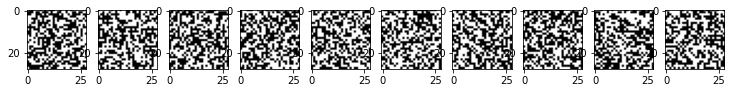

In [7]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(train_loader[0][0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

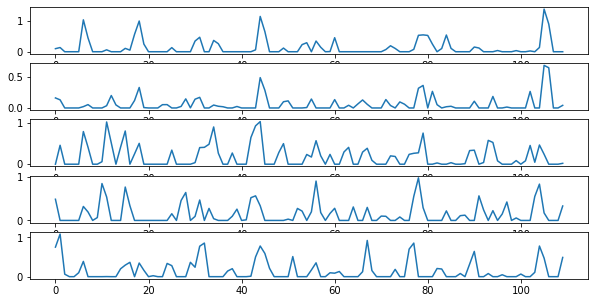

In [8]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
for ii in range(5):
    axes[ii].plot(train_loader[0][1][:,ii])

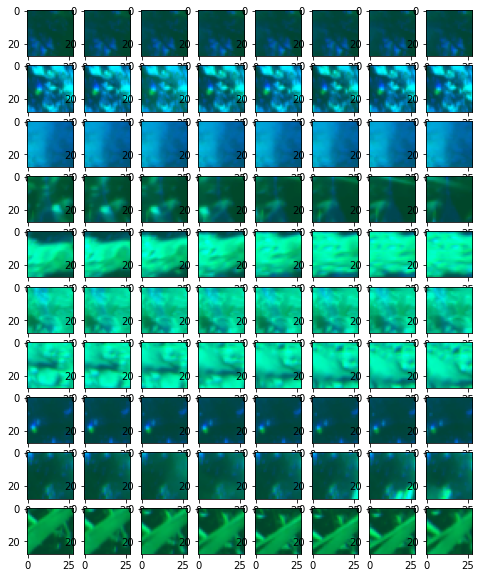

In [9]:
fig, axes = plt.subplots(nrows=10, ncols=8,figsize=(8,10))
for ii in range(10):
    for jj in range(8):
        temp=np.zeros((28,28,3),np.uint8)
        temp[...,1:]=np.transpose(train_loader[10][2][ii][:,jj,:,:],(1,2,0))[...,::-1]
        axes[ii,jj].imshow(img_real2view(temp))
        axes[ii,jj].grid(False)#axes[ii,jj].axis('tight')

In [10]:
#preprocess: centered data
sky_bg_mean_f   = np.mean(movie_bgr_h5[:36000,:,:-1,:,:],axis=(0,2,3,4))/255.0
print(sky_bg_mean_f)

[0.19401256 0.20572354]


In [11]:
#function: visualize conv0 weights
def Vis_conv3d_0(conv3d_0,temptitle,save=False,filename=None): # conv3d_0.shape (16, 2, 8, 9, 9)
    (outd,_,_,_,_)=conv3d_0.shape
    fig, axes = plt.subplots(nrows=3, ncols=outd,figsize=(outd, 3))
    for jj in range(outd):
        nt = 8 # time lag
        ny = 9
        nx = 9
        dims = [nt, ny, nx]
        [sRF_UV, tRF_UV]=mySVD(conv3d_0[jj,0], dims)
        [sRF_G, tRF_G]=mySVD(conv3d_0[jj,1], dims)
        tempmax=np.max(np.abs([sRF_UV,sRF_G]))
        axes[0,jj].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[0,jj].set_xticks([])
        axes[0,jj].set_yticks([])
        axes[0,jj].set_title('%d' %(jj))
        axes[1,jj].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
        axes[1,jj].set_xticks([])
        axes[1,jj].set_yticks([])
        axes[2,jj].plot(tRF_G,color='g')
        axes[2,jj].plot(tRF_UV,color='purple')
        axes[2,jj].axhline(y=0,color='k')
        axes[2,jj].spines['left'].set_visible(False)
        axes[2,jj].spines['bottom'].set_visible(False)
        axes[2,jj].spines['right'].set_visible(False)
        axes[2,jj].spines['top'].set_visible(False)
        axes[2,jj].set_xticks([])
        axes[2,jj].set_yticks([])
        axes[0,0].set_ylabel(str(temptitle))
        axes[0,0].set_title('%d_UV' %(0))
    if save==True:
        fig.savefig(filename)

##  <font color='red'>Model architecture</font> 

In [12]:
class ModelSemiSL3d1_Conv3d_1(nn.Module):
    def __init__(self):
        super().__init__()
        #supervised
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=96 #number of neurons
        self.conv1=nn.Parameter(torch.zeros(self.numoffea,2,8,9,9))
        std=1. / np.sqrt(2*8*9*9)
        self.conv1.data.uniform_(-std, std)
        self.conv1_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_bias.data.uniform_(-std, std)
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #autoencoder
        #
        self.ae_dconv1 =nn.ConvTranspose2d(self.numoffea,2,kernel_size=9,stride=1,padding=4) #2,28*28
        self.ae_fc1    =nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_dfc1   = nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_encoder = nn.Sequential(
            #self.conv1, #16,28*28
            nn.ReLU(),
            Flatten3D(),
            self.ae_fc1,
            nn.ReLU(),
            #GaussianNoise(sigma=0)
        )
        self.ae_decoder = nn.Sequential(
            self.ae_dfc1,
            nn.ReLU(),
            Unflatten(-1,self.numoffea,28,28),
            self.ae_dconv1, #2,28*28
            nn.Tanh())
    #
    def forward(self, x, z):
        #supervised
        encoded = F.relu(F.conv3d(x, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,0,0))) #16,20*20
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        #autoencoder
        #z          = z.unsqueeze(2) 
        ae_encoded = F.conv3d(z, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,4,4))
        ae_encoded = self.ae_encoder(ae_encoded)
        ae_decoded = self.ae_decoder(ae_encoded)
        #ae_decoded = ae_decoded.squeeze(2) 
        return encoded, ae_encoded, ae_decoded
#for visualization of RFs
class ModelSemiSL3d1_Conv3d_1_copy(nn.Module):
    def __init__(self,conv1,conv1_bias,fc1_weight,fc1_bias):
        super().__init__()
        self.numoffea=16 #number of features
        self.sizeoffea=20*20 #size of feature
        self.numofneuron=96 #number of neurons
        self.conv1=nn.Parameter(torch.zeros(self.numoffea,2,8,9,9))
        std=1. / np.sqrt(2*8*9*9)
        self.conv1.data.uniform_(-std, std)
        self.conv1_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_bias.data.uniform_(-std, std)
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #
        self.conv1.data.copy_(conv1.clone().detach())
        self.conv1_bias.data.copy_(conv1_bias.clone().detach())
        self.fc1.weight.data.copy_(fc1_weight.clone().detach())
        self.fc1.bias.data.copy_(fc1_bias.clone().detach())
    #
    def forward(self, x):
        encoded = F.relu(F.conv3d(x, self.conv1, bias=self.conv1_bias,stride=1,padding=(0,0,0))) #16,20*20
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        return encoded

##  <font color='red'>Different weights</font> 

In [19]:
EPOCH=100 
LR=2e-4 
alpha1s = [1e2]  # [1e2]
alpha2s = [0] #not play a role
beta1s  = [1/16] # [1/16]
alpha3s = [1e4]  # [1e4]
beta2s  = [1/16] # [1/16]
seeds   =[1]
lossweights=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1] # [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#modeltrainloss=[]
modelvalloss=[]
for ii in range(len(seeds)):
    for jj in range(len(lossweights)):
        seedname=str(ii+1)
        modelname=str(jj+1)
        torch.manual_seed(seeds[ii])    # reproducible
        torch.cuda.manual_seed(seeds[ii])
        tempmodel = ModelSemiSL3d1_Conv3d_1()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        model_train(tempmodel,train_loader,optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                    alpha1=alpha1s[0],alpha2=alpha2s[0],\
                    beta1=beta1s[0],alpha3=alpha3s[0],beta2=beta2s[0],lossweight=lossweights[jj],earlystop=True,verbose=True) 
        #modeltrainloss.append(temp)
        #
        torch.save(tempmodel.state_dict(),\
            './out/20200429_v5_ModelSemiSL3d1_Conv3d_1_dorsal_upandlow_seed_'+seedname+'_weight_'+modelname+'.pth')
        
        temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
        modelvalloss.append(temp)
        del tempmodel
        torch.cuda.empty_cache()

2020-12-26 11:08:52.013901
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  0 | train loss: 0.9775
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  1 | train loss: 0.4317
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  2 | train loss: 0.4178
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  3 | train loss: 0.4112
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  4 | train loss: 0.4095
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  5 | train loss: 0.4067
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  6 | train loss: 0.4043
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  7 | train loss: 0.4019
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  8 | train loss: 0.3996
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  9 | train loss: 0.3974
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  10 | train loss: 0.3952
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  11 | train loss: 0.3932
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  12 | train loss: 0.3912
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  13 | train loss: 0.3893
Model:  ModelSemiSL3d1_Conv3d_1 |Epoch:  14 | train loss: 0.3875
Model:  

In [20]:
print (modelvalloss)

[0.2833962169158506, 0.2879462079116773, 0.29179160228075157, 0.2965715099289804, 0.3033125507410137, 0.311987024212411, 0.30564653794973556, 0.283642582420926, 0.252183370433972]


## after hyperparameter tuning

In [ ]:
EPOCH=100 
LR=2e-4 # 1e-4
alpha1s = [1e2]  # [1e2]
alpha2s = [0] #not play a role
beta1s  = [1/16] # [1/16]
alpha3s = [1e4]  # [1e4]
beta2s  = [1/16] # [1/16]
seeds   = [1]
lossweights=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1] # [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#modeltrainloss=[]
modelvalloss=[]
for ii in range(len(seeds)):
    for jj in range(len(lossweights)):
        seedname=str(ii+2) #start from second seed
        modelname=str(jj+1)
        torch.manual_seed(seeds[ii])    # reproducible
        torch.cuda.manual_seed(seeds[ii])
        tempmodel = ModelSemiSL3d1_Conv3d_1()
        optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
        model_train(tempmodel,train_loader,optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                    alpha1=alpha1s[0],alpha2=alpha2s[0],\
                    beta1=beta1s[0],alpha3=alpha3s[0],beta2=beta2s[0],lossweight=lossweights[jj],earlystop=True,verbose=False) 
        #modeltrainloss.append(temp)
        #
        torch.save(tempmodel.state_dict(),\
            './out/20200429_v5_ModelSemiSL3d1_Conv3d_1_dorsal_upandlow_seed_'+seedname+'_weight_'+modelname+'.pth')
        temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
        modelvalloss.append(temp)
        del tempmodel
        torch.cuda.empty_cache()

## Val CC

In [13]:
#pca
valloss_pca=np.load('../data/20200429_ModelSE3d1_Exp_pca_Ploss_val_loss_v5.npy')
print (valloss_pca.shape)

(10, 8)


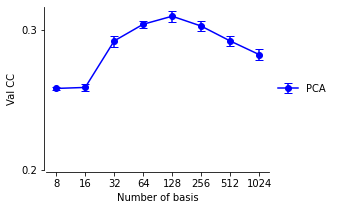

In [15]:
#plot, bootstrap
temps=[ii for ii in valloss_pca.T]
means = [np.mean(ii) for ii in temps]
lowqs=np.zeros(len(temps)) #lower_quartile
higqs=np.zeros(len(temps)) #upper_quartile
for ii in range(len(temps)):
    temp=temps[ii]
    low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
    lowqs[ii]  = means[ii]-low_perc
    higqs[ii]  =-means[ii]+high_perc 

numofbasis=[8,16,32,64,128,256,512,1024]
templabels=[]
for ii in range(len(numofbasis)):
    templabels.append(str(numofbasis[ii]))
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(4,3))
ax.errorbar(np.arange(len(means)),means, yerr=(lowqs,higqs),\
            marker='o', color='blue',linestyle='-', label='PCA',alpha=1, capsize=4)
#
ax.set_xticks(np.arange(len(means)).tolist())
ax.set_yticks([0.2,0.3])
#ax.set_ylim([0.22,0.33])
ax.set_xticklabels(templabels)
ax.set_xlabel('Number of basis')
ax.set_ylabel('Val CC')
ax.legend(loc='best')
adjust_spines(ax, ['left', 'bottom'])
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result/20200429_ModelSE3d1_Exp_pca_Ploss_dorsal_allSeeds_allbases_ValCCs_v5.svg', \
#            bbox_extra_artists=(lgd,), bbox_inches='tight')

## Test CC

In [16]:
testlosses=[]
#SNE
testloss_sne     =np.load('../data/20200429_ModelSE3d1_Exp_Ploss_test_loss_v5.npy')
print (testloss_sne.shape)
testlosses.append(testloss_sne)
#SNE-PCA
testloss_sne_pca =np.load('../data/20200429_ModelSE3d1_Exp_pca_Ploss_test_loss_v5.npy')
print (testloss_sne_pca.shape)
testlosses.append(testloss_sne_pca)
#HNE-Natural-past
testloss_hne_natural_past=np.load('../data/20200429_ModelSemiSL3d1_Conv3d_1_dorsal_upandlow_test_loss_v5.npy')
print (testloss_hne_natural_past.shape)
testlosses.append(testloss_hne_natural_past)
#HNE-Natural-future1
testloss_hne_natural_futu1=np.load('../data/20200429_ModelSemiSL3d1_Conv3d_2_dorsal_upandlow_test_loss_v5.npy')
print (testloss_hne_natural_futu1.shape)
testlosses.append(testloss_hne_natural_futu1)
#HNE-Natural-future2
testloss_hne_natural_futu2=np.load('../data/20200429_ModelSemiSL3d1_Conv3d_4_dorsal_upandlow_test_loss_v5.npy')
print (testloss_hne_natural_futu2.shape)
testlosses.append(testloss_hne_natural_futu2)
#
testlosses=np.array(testlosses)
print (testlosses.shape)

(10,)
(10,)
(10,)
(10,)
(10,)
(5, 10)


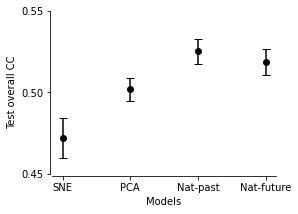

In [17]:
#plot
temps=[ii for ii in testlosses[:4]]
means = [np.mean(ii) for ii in temps]
lowqs=np.zeros(len(temps)) #lower_quartile
higqs=np.zeros(len(temps)) #upper_quartile
for ii in range(len(temps)):
    temp=temps[ii]
    low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
    lowqs[ii]  = means[ii]-low_perc
    higqs[ii]  =-means[ii]+high_perc 
#
templabels=['SNE','PCA','Nat-past','Nat-future']
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(4,3))
ax.errorbar(np.arange(len(means)),means, yerr=(lowqs,higqs),\
            marker='o', color='k',linestyle='None', alpha=1, capsize=4)
#
ax.set_xticks(np.arange(len(means)).tolist())
ax.set_yticks([0.45,0.50,0.55])
ax.set_xticklabels(templabels)
ax.set_xlabel('Models')
ax.set_ylabel('Test overall CC')
adjust_spines(ax, ['left', 'bottom'])
#ax.legend(loc='best')
#handles, labels = ax.get_legend_handles_labels()
#lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result/20200429_all3DModels_TestCCs.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [18]:
#permutation test
#https://stackoverflow.com/questions/24795535/pythons-implementation-of-permutation-test-with-permutation-number-as-input
#permutation test using monte-carlo method
def perm_test(xs, ys, nmc, randomseed):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc
def perm_test_group(list_of_array,nmc=10000,randomseed=66):
    perm_res=[]
    for ii in np.arange(len(list_of_array)):
        for jj in np.arange(ii+1,len(list_of_array)):
            temp=perm_test(list_of_array[ii], list_of_array[jj], nmc, (ii*jj+jj+randomseed)*nmc)
            perm_res.append(temp)
    return perm_res
#
temp=[testlosses[0], testlosses[1], testlosses[2], testlosses[3]]
print (perm_test_group(temp,nmc=10000,randomseed=66))

[0.0007, 0.0, 0.0, 0.0005, 0.0083, 0.2563]


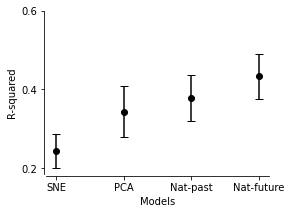

In [19]:
#conv0, fit to 2d Gaussian, measure goodness, for 4 tyeps of models and 10 random seeds
#only green channel, bootstrap
cha = 1 # UV, G = 0, 1
r2_ss=np.zeros((4,160)) # 160 = 10(seeds) x 16(kernels) x 1(colour)
#SNE
r2_ss[0] =np.load('../data/20200429_ModelSE3d1_Exp_dorsal_conv0_fit_r2_v5.npy').reshape(-1,2)[:,cha]
#SNE-PCA
r2_ss[1] =np.load('../data/20200429_ModelSE3d1_Exp_pca_dorsal_conv0_fit_r2_v5.npy').reshape(-1,2)[:,cha]
#HNE-natural-past
r2_ss[2] =np.load('../data/20200429_ModelSemiSL3d1_Conv3d_1_dorsal_upandlow_conv0_fit_r2_v5.npy').reshape(-1,2)[:,cha]
#HNE-natural-future1
r2_ss[3] =np.load('../data/20200429_ModelSemiSL3d1_Conv3d_2_dorsal_upandlow_conv0_fit_r2_v5.npy').reshape(-1,2)[:,cha]
#
temps=[ii for ii in r2_ss]
means = [np.mean(ii) for ii in temps]
lowqs=np.zeros(len(temps)) #lower_quartile
higqs=np.zeros(len(temps)) #upper_quartile
for ii in range(len(temps)):
    temp=temps[ii]
    low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
    lowqs[ii]  = means[ii]-low_perc
    higqs[ii]  =-means[ii]+high_perc 
#
templabels=['SNE','PCA','Nat-past','Nat-future']
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(4,3))
ax.errorbar(np.arange(len(means)),means,yerr=(lowqs,higqs),\
            marker='o', color='k',linestyle='None', alpha=1, capsize=4)
#
ax.set_yticks([0.2,0.4,0.6])
ax.set_xticks(np.arange(len(means)).tolist())
ax.set_xticklabels(templabels)
ax.set_xlabel('Models')
ax.set_ylabel('R-squared')
adjust_spines(ax, ['left', 'bottom'])
#ax.legend(loc='best')
#handles, labels = ax.get_legend_handles_labels()
#lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result/20200429_all2DModels_TestCCs.svg', \
#            bbox_extra_artists=(lgd,), bbox_inches='tight')
#fig.savefig('out_result/20200429_ModelSemiSL3d1_dorsal_all_3dmodels_r2s.svg')

In [20]:
#permutation test
def perm_test(xs, ys, nmc, randomseed):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.seed(randomseed+j)
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc
def perm_test_group(list_of_array,nmc=10000,randomseed=66):
    perm_res=[]
    for ii in np.arange(len(list_of_array)):
        for jj in np.arange(ii+1,len(list_of_array)):
            temp=perm_test(list_of_array[ii], list_of_array[jj], nmc, (ii*jj+jj+randomseed)*nmc)
            perm_res.append(temp)
    return perm_res
#
temp=[ii for ii in r2_ss]
print (perm_test_group(temp,nmc=10000,randomseed=66))

[0.0119, 0.0003, 0.0, 0.4356, 0.0427, 0.1895]
